In [ ]:
import pickle
import numpy as np


In [ ]:
with open("train_qa.txt", "rb") as f:
    train_data = pickle.load(f)


In [ ]:
with open("test_qa.txt", "rb") as f:
    test_data = pickle.load(f)

In [ ]:
type(train_data)

list

In [ ]:
len(train_data)

10000

In [ ]:
len(test_data)

1000

In [ ]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [ ]:
all_data = test_data + train_data

In [ ]:
len(all_data)

11000

In [ ]:
vocab = set()
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))


In [ ]:
vocab.add("no")
vocab.add("yes")

In [ ]:
vocab


{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
vocab_len = len(vocab) + 1
vocab_len

38

In [ ]:
all_story_len = [len(data[0]) for data in all_data]
max_story_len = max(all_story_len)
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [ ]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(filters = [])

In [ ]:
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'john': 1,
 'mary': 2,
 'discarded': 3,
 '?': 4,
 'sandra': 5,
 'left': 6,
 'bedroom': 7,
 'there': 8,
 'grabbed': 9,
 'moved': 10,
 'to': 11,
 'put': 12,
 'went': 13,
 'daniel': 14,
 'office': 15,
 'picked': 16,
 'got': 17,
 'travelled': 18,
 'kitchen': 19,
 'back': 20,
 'the': 21,
 'milk': 22,
 'apple': 23,
 'up': 24,
 'hallway': 25,
 'garden': 26,
 'yes': 27,
 'down': 28,
 'football': 29,
 'no': 30,
 'is': 31,
 'dropped': 32,
 'took': 33,
 'bathroom': 34,
 'in': 35,
 '.': 36,
 'journeyed': 37}

In [ ]:
train_story_text = []
train_question_text = []
train_answers = []

In [ ]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [ ]:
train_story_sequence = tokenizer.texts_to_sequences(train_story_text)
# train_question_sequence = tokenizer.texts_to_sequences(train_question_text)

In [ ]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    x = []
    xq = []
    y = []
    for story, question, answer in data:
        x_temp = [word_index[word.lower()] for word in story]
        xq_temp = [word_index[word.lower()] for word in question]        
        y_temp = np.zeros(len(word_index)+1)
        y_temp[word_index[answer]] = 1
        x.append(x_temp)
        xq.append(xq_temp)        
        y.append(y_temp)
    return (pad_sequences(x,maxlen = max_story_len),pad_sequences(xq,maxlen = max_question_len), np.array(y))


In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [ ]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [ ]:
from keras.models import Sequential, Model

In [ ]:
from keras.layers import Embedding 

In [ ]:
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [ ]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [ ]:
vocab_size = len(vocab)+1

In [ ]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [ ]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [ ]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [ ]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)


In [ ]:
match = dot([input_encoded_m, question_encoded], axes = (2,2))

In [ ]:
match = Activation("softmax")(match)

In [ ]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [ ]:
answer = concatenate([response, question_encoded])

In [ ]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [ ]:
answer = LSTM(32)(answer)

In [ ]:
answer = Dropout(0.5)(answer)

In [ ]:
answer = Dense(vocab_size)(answer)

In [ ]:
answer = Activation("softmax")(answer)

In [ ]:
model = Model([input_sequence, question], answer)

In [ ]:
model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs = 200, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/200
313/313 [==============================] - 8s 17ms/step - loss: 0.8548 - accuracy: 0.4856 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 2/200
313/313 [==============================] - 5s 15ms/step - loss: 0.7006 - accuracy: 0.4889 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 3/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6948 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 4/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6946 - accuracy: 0.5084 - val_loss: 0.6940 - val_accuracy: 0.5030
Epoch 5/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6950 - accuracy: 0.4984 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 6/200
313/313 [==============================] - 5s 17ms/step - loss: 0.6945 - accuracy: 0.4976 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 7/200
313/313 [==============================] - 5s 15ms/step - loss: 0.6943 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy:

In [ ]:
filename = "chatbot.h5"
model.save(filename)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


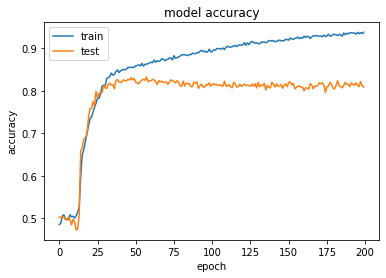

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 4ms/step


In [ ]:
pred_results

array([[3.4916373e-12, 3.2735650e-12, 3.2660682e-12, ..., 3.2937067e-12,
        3.5724763e-12, 3.5921956e-12],
       [8.2275387e-14, 7.5386610e-14, 7.7533310e-14, ..., 8.0530905e-14,
        8.4242556e-14, 8.5230061e-14],
       [7.2345946e-10, 7.1160372e-10, 6.9601364e-10, ..., 6.9017980e-10,
        7.1475548e-10, 7.2320977e-10],
       ...,
       [3.8565496e-12, 3.4218136e-12, 3.5992685e-12, ..., 3.7502072e-12,
        3.8716213e-12, 3.8796197e-12],
       [1.8696747e-11, 1.8212569e-11, 1.9216871e-11, ..., 1.9086828e-11,
        1.9632554e-11, 1.9169426e-11],
       [6.7619983e-15, 6.2760758e-15, 6.6467086e-15, ..., 6.3639030e-15,
        5.7242715e-15, 5.7654716e-15]], dtype=float32)

In [ ]:
pred_results[0]

array([3.4916373e-12, 3.2735650e-12, 3.2660682e-12, 3.3376589e-12,
       3.5882785e-12, 3.4892009e-12, 3.2720042e-12, 3.4554638e-12,
       3.5150916e-12, 3.2835952e-12, 3.3159452e-12, 3.2607153e-12,
       3.4969428e-12, 3.3272475e-12, 3.2538813e-12, 3.3752892e-12,
       3.4550947e-12, 3.1890350e-12, 3.4634611e-12, 3.2066010e-12,
       3.3022491e-12, 3.1830916e-12, 3.2571224e-12, 3.4215699e-12,
       3.2948377e-12, 3.5218430e-12, 3.4387768e-12, 1.0073498e-03,
       3.4722583e-12, 3.3636312e-12, 9.9899268e-01, 3.1501028e-12,
       3.4919173e-12, 3.4857553e-12, 3.2328359e-12, 3.2937067e-12,
       3.5724763e-12, 3.5921956e-12], dtype=float32)

In [ ]:
val_max = np.argmax(pred_results[0])

In [ ]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [ ]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [ ]:
test_data[0][2]

'no'

In [ ]:
for key, val in tokenizer.word_index.items():
    if val==val_max:
        k = key


In [ ]:
k

'no'

In [ ]:
pred_results[0][val_max]

0.9989927

In [ ]:
my_story = "John left the kitchen . Sandra dropped football in the garden ."

In [ ]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [ ]:
my_question = "Is the football in the garden ?"

In [ ]:
mydata = [(my_story.split(), my_question.split(), "yes")]

In [ ]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [ ]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [ ]:
ans = model.predict(([my_story, my_ques]))

1/1 [==============================] - 0s 25ms/step


In [ ]:
ans

array([[1.8357260e-12, 1.7141456e-12, 1.9198985e-12, 1.6807474e-12,
        1.6672988e-12, 1.6828485e-12, 1.8760037e-12, 1.6542796e-12,
        1.6835708e-12, 1.6276790e-12, 1.9984778e-12, 1.8369974e-12,
        1.6731159e-12, 1.6530811e-12, 1.8038599e-12, 1.9822447e-12,
        1.8252379e-12, 1.8108164e-12, 1.6736201e-12, 1.7377820e-12,
        1.7114113e-12, 1.7664245e-12, 1.7658451e-12, 1.7837354e-12,
        1.6596682e-12, 1.7385710e-12, 1.6466048e-12, 6.9106543e-05,
        1.9372939e-12, 1.9085653e-12, 9.9993086e-01, 1.6763165e-12,
        1.7785512e-12, 1.7207430e-12, 1.7364567e-12, 1.7027893e-12,
        1.6426648e-12, 1.6749294e-12]], dtype=float32)

In [ ]:
np.argmax(ans)

30

In [ ]:
ans[0][23]

1.7837354e-12

In [ ]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}